<h1 style="text-align:center;color:teal;font-family:calibri;font-size:250%">Bike Sharing Assignment using Multiple Linear Regression </h1>

### Problem Statemant:

A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state. 

They have contracted a consulting company to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:

- Which variables are significant in predicting the demand for shared bikes.
- How well those variables describe the bike demands



### Import libraries

In [2]:
#import the warnings.
import warnings
warnings.filterwarnings("ignore")

In [3]:
#import the visualisation libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option("display.max_columns",None)

In [4]:
#import the ML libraries
import statsmodels.api as sm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

### Read the Dataset

In [5]:
bikes = pd.read_csv("BoomBikes.csv")
bikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### Data Inspection

#### Get info and shape on the dataset

In [6]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


#### --> No null values found in the dataset

In [7]:
bikes.shape

(730, 16)

#### --> 730 rows and 16 columns found

#### Dropping the below Columns

- instant: record index is not useful for prediction as it is a continuous index variable
- dteday : date is not useful for prediction as it is redundent
- casual: count of casual users cannot be used as it is directly correlating with target varible count 
- registered: count of registered users as it is directly correlating with target varible count

#### Target Variable for Prediction is Cnt

- cnt: count of total rental bikes including both casual and registered

In [8]:
bikes.drop(['instant','dteday','casual','registered'], axis = 1, inplace = True)

In [9]:
bikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,1600


#### Converting the numerically encoded categorical Columns to appropriate object data type

- season : season (1:spring, 2:summer, 3:fall, 4:winter)
- mnth : month ( 1 to 12)
- weekday : day of the week
- weathersit : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

In [10]:
bikes["season"] = bikes["season"].map({1:'spring',2:'summer',3:'fall',4:'winter'})

month_labels = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
bikes["mnth"] = bikes["mnth"].map(month_labels)

day_labels = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thur', 5: 'Fri', 6: 'Sat', 0: 'Sun'}
bikes["weekday"] = bikes["weekday"].map(day_labels)

bikes["weathersit"] = bikes["weathersit"].map({1:'Clear',2:'Mist_and_Cloudy',3:'Light_Rain',4:'Heavy_rain'})

In [11]:
#Renaming the columns
bikes.rename(columns = {'yr':'year', 'mnth':'month','hum':'humidity','cnt':'rental_count'}, inplace = True)

In [12]:
bikes.head()

,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,rental_count
0,spring,0,Jan,0,Mon,1,Mist_and_Cloudy,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,Jan,0,Tue,1,Mist_and_Cloudy,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,Jan,0,Wed,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,Jan,0,Thur,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,Jan,0,Fri,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


### Data Visualisation on the bikes dataset

In [13]:
#Numerical Variables
num_vars = ["temp","atemp","humidity","windspeed","rental_count"]
#Categorical Variables
cat_vars = ["season","year","month","holiday","weekday","workingday","weathersit"]

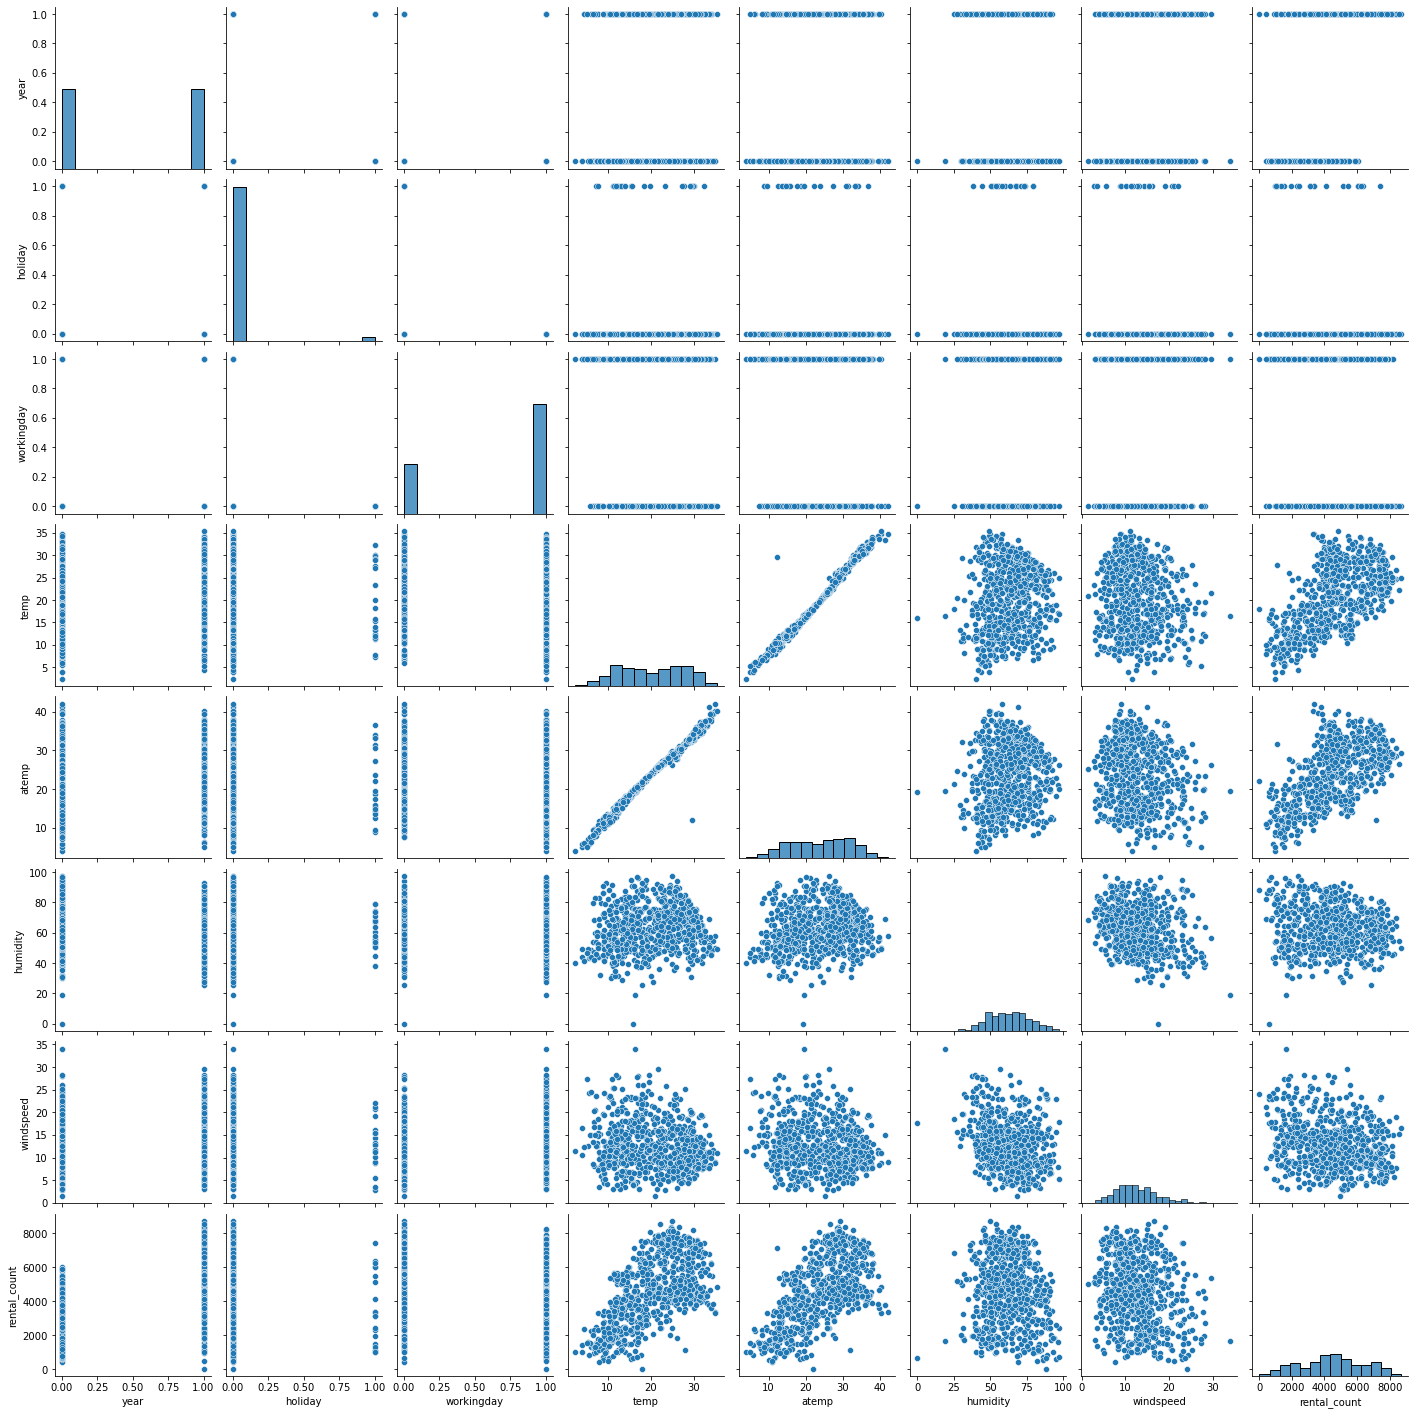

In [14]:
#Plotting pair plots for numerical variables
sns.pairplot(bikes)
plt.show()

### Conclusion :

- temp and atemp are highly correlated, hence we can drop atemp column
- temp and the target variable sales_count have a positive corelation

### Exploring the correlation between different numerical variables

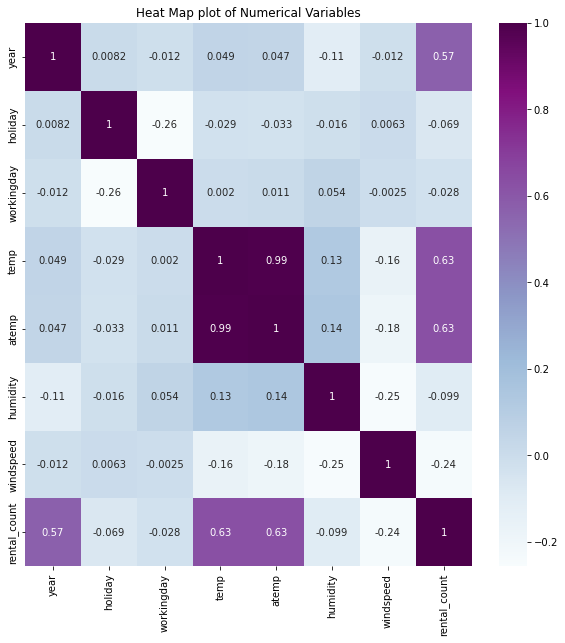

In [15]:
plt.figure(figsize=[10,10])
sns.heatmap(bikes.corr(),annot=True,cmap='BuPu')
plt.title("Heat Map plot of Numerical Variables")
plt.show()

### Conclusion :

- Sales has positive correlation of 0.57 with year, 0.63 with temperature 
- Sales has Negative correlation of 0.099 and 0.24 with humidity and windspeed respectively.
- Holiday has workingday have Negative correlation of 0.069 and 0.028 with Sales.
- temp and atemp have a high positive correlation of 0.99

In [16]:
#Dropping atemp since temp and atemp have a high positive correlation of 0.99
bikes.drop(columns=["atemp"],axis=1,inplace=True)

In [17]:
bikes.head()

,season,year,month,holiday,weekday,workingday,weathersit,temp,humidity,windspeed,rental_count
0,spring,0,Jan,0,Mon,1,Mist_and_Cloudy,14.110847,80.5833,10.749882,985
1,spring,0,Jan,0,Tue,1,Mist_and_Cloudy,14.902598,69.6087,16.652113,801
2,spring,0,Jan,0,Wed,1,Clear,8.050924,43.7273,16.636703,1349
3,spring,0,Jan,0,Thur,1,Clear,8.200000,59.0435,10.739832,1562
4,spring,0,Jan,0,Fri,1,Clear,9.305237,43.6957,12.522300,1600


### Plotting Box plots for categorical variables

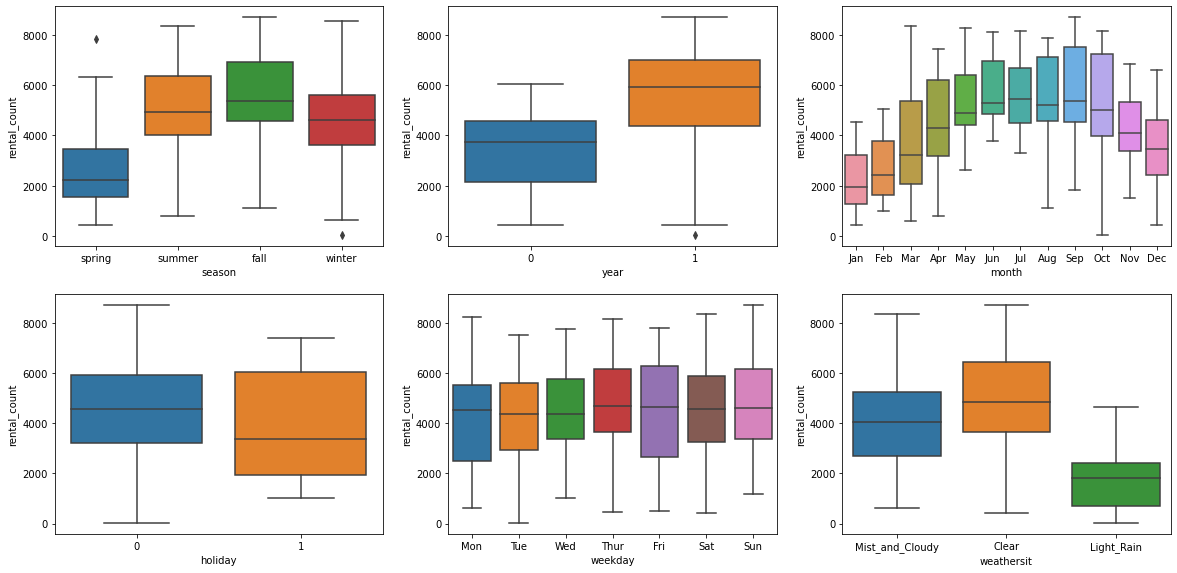

In [18]:
plt.figure(figsize=(20, 15))
plt.subplot(3,3,1)
sns.boxplot(x='season',y='rental_count',data=bikes)
plt.subplot(3,3,2)
sns.boxplot(x='year',y='rental_count',data=bikes)
plt.subplot(3,3,3)
sns.boxplot(x='month',y='rental_count',data=bikes)
plt.subplot(3,3,4)
sns.boxplot(x='holiday',y='rental_count',data=bikes)
plt.subplot(3,3,5)
sns.boxplot(x='weekday',y='rental_count',data=bikes)
plt.subplot(3,3,6)
sns.boxplot(x='weathersit',y='rental_count',data=bikes)
plt.show()

### Conclusion :

- The Count of bike rentals is increased during Summer and fall seasons and started decreasing during winter and spring.
- There is a gradual increase in bike rentals from 2018 to 2019.
- September has the highest number of rental counts and there is a fall in the median after that till December and a gradual     increase from January
- The median of the rental counts is almost same for all the days.
- The bike rental count is high when the sky is clear and is gradually decresing when its cloudy or raining.

### Distribution of Values in Categotical Columns with pie plots

fall      0.257534
summer    0.252055
spring    0.246575
winter    0.243836
Name: season, dtype: float64


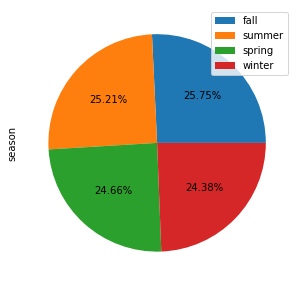

0    0.5
1    0.5
Name: year, dtype: float64


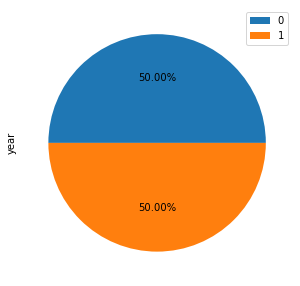

Jan    0.084932
Mar    0.084932
May    0.084932
Jul    0.084932
Aug    0.084932
Oct    0.084932
Dec    0.084932
Apr    0.082192
Jun    0.082192
Sep    0.082192
Nov    0.082192
Feb    0.076712
Name: month, dtype: float64


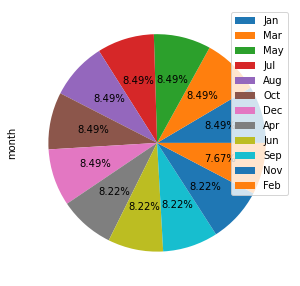

0    0.971233
1    0.028767
Name: holiday, dtype: float64


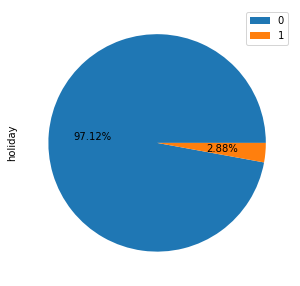

Mon     0.143836
Tue     0.143836
Wed     0.142466
Thur    0.142466
Fri     0.142466
Sat     0.142466
Sun     0.142466
Name: weekday, dtype: float64


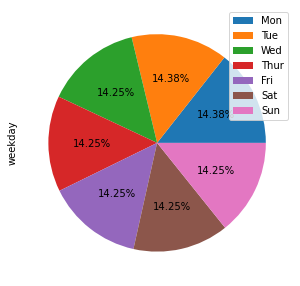

1    0.690411
0    0.309589
Name: workingday, dtype: float64


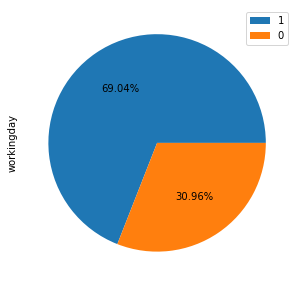

Clear              0.634247
Mist_and_Cloudy    0.336986
Light_Rain         0.028767
Name: weathersit, dtype: float64


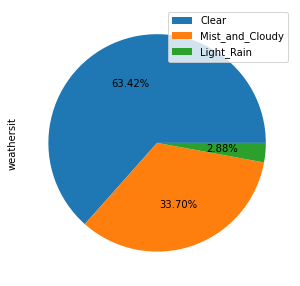

In [19]:
for col in cat_vars:
    print(bikes[col].value_counts(normalize=True))
    plt.figure(figsize=[5,5])
    bikes[col].value_counts(normalize=True).plot.pie(labeldistance=None,autopct='%1.2f%%')
    plt.legend()
    plt.show()

### Conclusion:

- The data is distributed equally for each categories in season, year, month, weekday variables

### Bivarient / Multivarient Analysis on the dataset

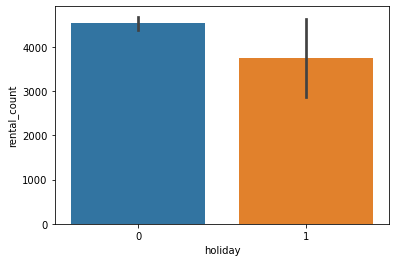

In [20]:
# Plot of Holiday VS Rental Count
sns.barplot(x='holiday',y='rental_count',data=bikes)
plt.show()

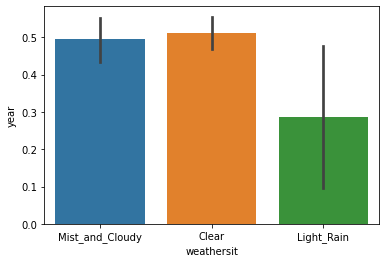

In [21]:
# Plot of weathersit VS Rental Count
sns.barplot(x='weathersit',y='year',data=bikes)
plt.show()

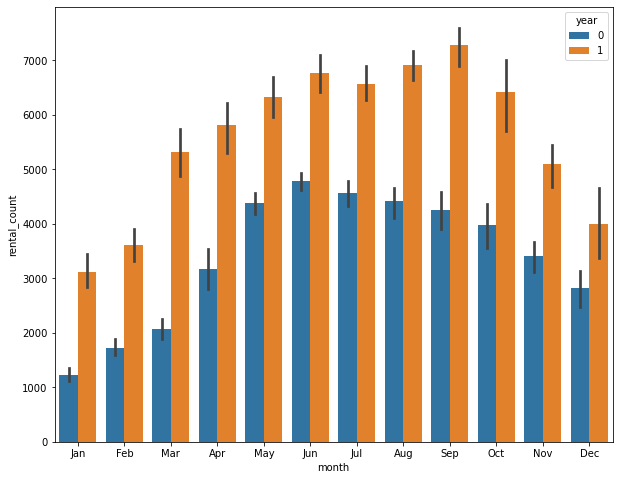

In [22]:
# Plot of Month VS Rental Count based on year
plt.figure(figsize=[10,8])
sns.barplot(x='month',y='rental_count',hue='year',data=bikes)
plt.show()

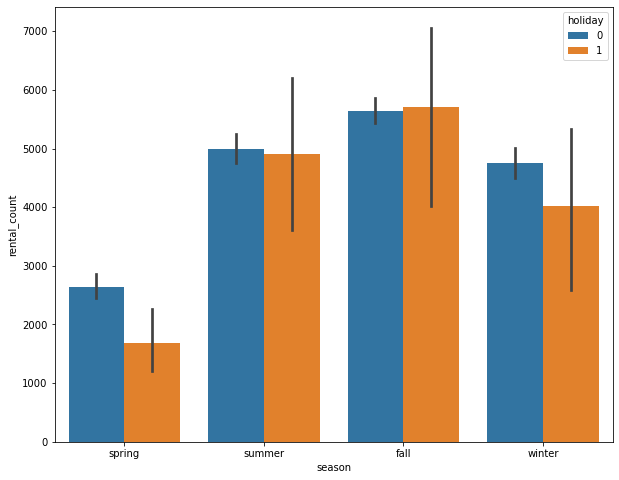

In [23]:
# Plot of Season VS Rental Count based on holiday
plt.figure(figsize=[10,8])
sns.barplot(x='season',y='rental_count',hue='holiday',data=bikes)
plt.show()

### Conclusion:

- The count of bike rentals is less on a holiday compared to a weekday or non-holiday.
- Bike Rentals is high when sky is clear and less when it is cloudy and no rentals during heavy rain.
- Throught the year from January to mid-year the bike rentals is increasing and decreasing after that during 2018 and a similar pattern is observed in 2019 where there is a increase in rentals till september and a downfall after that
- During Summer and fall season the bike rental count is the same whether it is a holiday or not and decrease in rentals if it is holiday during spring and winter

### Data Preparation

### 1a. Create Dummy variables for categorical varaibles

In [24]:
months_dummies=pd.get_dummies(bikes.month,drop_first=True)
weekdays_dummies=pd.get_dummies(bikes.weekday,drop_first=True)
weathersit_dummies=pd.get_dummies(bikes.weathersit,drop_first=True)
seasons_dummies=pd.get_dummies(bikes.season,drop_first=True)

In [25]:
#Concat with the previous dataframe
bikes_df=pd.concat([bikes,months_dummies,weekdays_dummies,weathersit_dummies,seasons_dummies],axis=1)
bikes_df.head()

,season,year,month,holiday,weekday,workingday,weathersit,temp,humidity,windspeed,rental_count,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Mon,Sat,Sun,Thur,Tue,Wed,Light_Rain,Mist_and_Cloudy,spring,summer,winter
0,spring,0,Jan,0,Mon,1,Mist_and_Cloudy,14.110847,80.5833,10.749882,985,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0
1,spring,0,Jan,0,Tue,1,Mist_and_Cloudy,14.902598,69.6087,16.652113,801,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0
2,spring,0,Jan,0,Wed,1,Clear,8.050924,43.7273,16.636703,1349,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,spring,0,Jan,0,Thur,1,Clear,8.200000,59.0435,10.739832,1562,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,spring,0,Jan,0,Fri,1,Clear,9.305237,43.6957,12.522300,1600,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### 1b. Drop the categorical varaibles for which dummy values are created

In [26]:
bikes_df.drop(columns = ["month","weekday","season","weathersit"], axis=1, inplace = True)

In [27]:
bikes_df.head()

,year,holiday,workingday,temp,humidity,windspeed,rental_count,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Mon,Sat,Sun,Thur,Tue,Wed,Light_Rain,Mist_and_Cloudy,spring,summer,winter
0,0,0,1,14.110847,80.5833,10.749882,985,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0
1,0,0,1,14.902598,69.6087,16.652113,801,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0
2,0,0,1,8.050924,43.7273,16.636703,1349,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
3,0,0,1,8.200000,59.0435,10.739832,1562,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,0,0,1,9.305237,43.6957,12.522300,1600,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### 2. Divide the dataset to test and train data

In [28]:
bikes_df_train, bikes_df_test = train_test_split(bikes_df, train_size = 0.7, test_size=0.3, random_state = 100)

In [29]:
bikes_df_train.head()

,year,holiday,workingday,temp,humidity,windspeed,rental_count,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Mon,Sat,Sun,Thur,Tue,Wed,Light_Rain,Mist_and_Cloudy,spring,summer,winter
653,1,0,1,19.201653,55.8333,12.208807,7534,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
576,1,0,1,29.246653,70.4167,11.083475,7216,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
426,1,0,0,16.980847,62.1250,10.792293,4066,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0
728,1,0,1,10.489153,48.3333,23.500518,1796,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
482,1,0,0,15.443347,48.9583,8.708325,4220,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0


### 3. Scale the train data (using MinMax Scalar)

In [30]:
num_vars = ["temp","humidity","windspeed","rental_count"] # define numerical variables
scaler = MinMaxScaler() # create scalar object
bikes_df_train[num_vars] = scaler.fit_transform(bikes_df_train[num_vars]) # fit the data

In [31]:
bikes_df_train.head()

,year,holiday,workingday,temp,humidity,windspeed,rental_count,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Mon,Sat,Sun,Thur,Tue,Wed,Light_Rain,Mist_and_Cloudy,spring,summer,winter
653,1,0,1,0.509887,0.575354,0.300794,0.864243,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
576,1,0,1,0.815169,0.725633,0.264686,0.827658,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
426,1,0,0,0.442393,0.640189,0.255342,0.465255,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0
728,1,0,1,0.245101,0.498067,0.663106,0.204096,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
482,1,0,0,0.395666,0.504508,0.188475,0.482973,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0


In [32]:
# Validate if the scaling is done properly by checking the max and min values
bikes_df_train[num_vars].describe()

,temp,humidity,windspeed,rental_count
count,510.000000,510.000000,510.000000,510.000000
mean,0.537262,0.650369,0.320768,0.513620
std,0.225844,0.145882,0.169797,0.224593
min,0.000000,0.000000,0.000000,0.000000
25%,0.339853,0.538643,0.199179,0.356420
50%,0.540519,0.653714,0.296763,0.518638
75%,0.735215,0.754830,0.414447,0.684710
max,1.000000,1.000000,1.000000,1.000000


### 4. Divide the data into X and y 

In [33]:
y_train = bikes_df_train.pop("rental_count")
X_train = bikes_df_train

### Training the Model

### 1. Extracting the top 15 features using RFE

In [34]:
lm = LinearRegression() # create a linearRegression object
rfe = RFE(lm, 15) # define the number of features
rfe.fit(X_train, y_train) # fit the data

RFE(estimator=LinearRegression(), n_features_to_select=15)

In [35]:
#create the list of columns obtained from RFE
col = list(X_train.columns[rfe.support_])
col

['year',
 'holiday',
 'temp',
 'humidity',
 'windspeed',
 'Dec',
 'Jan',
 'Jul',
 'Nov',
 'Sep',
 'Light_Rain',
 'Mist_and_Cloudy',
 'spring',
 'summer',
 'winter']

In [36]:
#Select the list of columns obtained from RFE
X_train_rfe = X_train[col]
X_train_rfe.head()

,year,holiday,temp,humidity,windspeed,Dec,Jan,Jul,Nov,Sep,Light_Rain,Mist_and_Cloudy,spring,summer,winter
653,1,0,0.509887,0.575354,0.300794,0,0,0,0,0,0,0,0,0,1
576,1,0,0.815169,0.725633,0.264686,0,0,1,0,0,0,0,0,0,0
426,1,0,0.442393,0.640189,0.255342,0,0,0,0,0,0,1,1,0,0
728,1,0,0.245101,0.498067,0.663106,1,0,0,0,0,0,0,1,0,0
482,1,0,0.395666,0.504508,0.188475,0,0,0,0,0,0,1,0,1,0


### 2. Modelling the data using statsmodel

### Model - 1

In [37]:
X_train_rfe = sm.add_constant(X_train_rfe) # Add a constant
lm_model = sm.OLS(y_train, X_train_rfe).fit() # Create the model using Ordinary least Squares method in statsmodel
lm_model.summary() # view the summary of the model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rental_count   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     180.2
Date:                Tue, 05 Jul 2022   Prob (F-statistic):          3.34e-189
Time:                        22:05:52   Log-Likelihood:                 514.72
No. Observations:                 510   AIC:                            -997.4
Df Residuals:                     494   BIC:                            -929.7
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3202      0.036      8.886      0.000       0.249       0.391
year                0.2303      0.008     28.511      0.000       0.214       0.246
holiday            -0.0912      0.026     -3.566      0.000      -0.141      -0.041
temp                0.4800      0.037     12.977      0.000       0.407       0.553
humidity           -0.1602      0.038     -4.240      0.000      -0.234      -0.086
windspeed          -0.1885      0.026     -7.312      0.000      -0.239      -0.138
Dec                -0.0372      0.017     -2.131      0.034      -0.071      -0.003
Jan                -0.0437      0.018     -2.415      0.016      -0.079      -0.008
Jul                -0.0555      0.018     -3.046      0.002      -0.091      -0.020
Nov                -0.0409      0.019     -2.187      0.029      -0.078      -0.004
Sep                 0.0749      0.017      4.438      0.000       0.042       0.108
Light_Rain         -0.2481      0.026     -9.402      0.000      -0.300      -0.196
Mist_and_Cloudy    -0.0559      0.010     -5.338      0.000      -0.076      -0.035
spring             -0.0617      0.021     -2.907      0.004      -0.103      -0.020
summer              0.0408      0.015      2.659      0.008       0.011       0.071
winter              0.1034      0.018      5.763      0.000       0.068       0.139
==============================================================================
Omnibus:                       67.327   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.896
Skew:                          -0.684   Prob(JB):                     1.56e-36
Kurtosis:                       5.427   Cond. No.                         20.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
# Checking the Multicollinearity between Predictor variables using Variable Inflation Factor(VIF)
X_train_vif = X_train_rfe.drop(columns = 'const', axis = 1) # drop the constant
vif = pd.DataFrame() # define vif object
vif['features'] = X_train_vif.columns # select the feature variables
vif['VIF'] = [variance_inflation_factor(X_train_vif.values, i) for i in range(len(X_train_vif.columns))] # Extarct the VIF Values for all features
vif['VIF'] = round(vif['VIF'],2) # round the VIF to 2 decimals
vif = vif.sort_values(by ='VIF', ascending =False) # sort the VIFs by descending order
vif

,features,VIF
3,humidity,30.94
2,temp,17.80
4,windspeed,4.72
12,spring,4.37
14,winter,4.06
13,summer,2.81
11,Mist_and_Cloudy,2.32
0,year,2.09
8,Nov,1.83
6,Jan,1.75


####  We can see that the p-value Dec Variable is higher compared to others, hence dropping Dec

In [39]:
X_train_1 = X_train_rfe.drop(["Dec"], axis = 1)

### Model - 2

In [40]:
X_train_rfe = sm.add_constant(X_train_1)
lm_model = sm.OLS(y_train, X_train_rfe).fit()
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rental_count   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     191.4
Date:                Tue, 05 Jul 2022   Prob (F-statistic):          2.25e-189
Time:                        22:05:54   Log-Likelihood:                 512.39
No. Observations:                 510   AIC:                            -994.8
Df Residuals:                     495   BIC:                            -931.3
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3030      0.035      8.597      0.000       0.234       0.372
year                0.2301      0.008     28.386      0.000       0.214       0.246
holiday            -0.0922      0.026     -3.592      0.000      -0.143      -0.042
temp                0.5052      0.035     14.369      0.000       0.436       0.574
humidity           -0.1682      0.038     -4.457      0.000      -0.242      -0.094
windspeed          -0.1854      0.026     -7.179      0.000      -0.236      -0.135
Jan                -0.0339      0.018     -1.929      0.054      -0.068       0.001
Jul                -0.0562      0.018     -3.076      0.002      -0.092      -0.020
Nov                -0.0253      0.017     -1.463      0.144      -0.059       0.009
Sep                 0.0798      0.017      4.755      0.000       0.047       0.113
Light_Rain         -0.2418      0.026     -9.187      0.000      -0.293      -0.190
Mist_and_Cloudy    -0.0543      0.010     -5.182      0.000      -0.075      -0.034
spring             -0.0564      0.021     -2.664      0.008      -0.098      -0.015
summer              0.0466      0.015      3.080      0.002       0.017       0.076
winter              0.0986      0.018      5.519      0.000       0.064       0.134
==============================================================================
Omnibus:                       60.875   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              140.686
Skew:                          -0.640   Prob(JB):                     2.82e-31
Kurtosis:                       5.233   Cond. No.                         20.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
# Checking the Multicollinearity between Predictor variables using Variable Inflation Factor(VIF)
X_train_vif = X_train_rfe.drop(columns = 'const', axis = 1)
vif = pd.DataFrame()
vif['features'] = X_train_vif.columns
vif['VIF'] = [variance_inflation_factor(X_train_vif.values, i) for i in range(len(X_train_vif.columns))]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by ='VIF', ascending =False)
vif

,features,VIF
3,humidity,29.12
2,temp,16.80
4,windspeed,4.71
11,spring,4.37
13,winter,3.78
12,summer,2.79
10,Mist_and_Cloudy,2.29
0,year,2.09
5,Jan,1.67
6,Jul,1.59


#### After dropping the Dec variable we saw a drop in r2 and adj(r2) by 0.1 % , Next we can drop Nov variable because it has higher p-value of 0.144 compared to others

In [42]:
X_train_2 = X_train_rfe.drop(["Nov"], axis = 1)

### Model - 3

In [43]:
X_train_rfe = sm.add_constant(X_train_2)
lm_model = sm.OLS(y_train, X_train_rfe).fit()
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rental_count   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     205.5
Date:                Tue, 05 Jul 2022   Prob (F-statistic):          4.45e-190
Time:                        22:05:55   Log-Likelihood:                 511.29
No. Observations:                 510   AIC:                            -994.6
Df Residuals:                     496   BIC:                            -935.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2957      0.035      8.466      0.000       0.227       0.364
year                0.2301      0.008     28.348      0.000       0.214       0.246
holiday            -0.0968      0.026     -3.796      0.000      -0.147      -0.047
temp                0.5127      0.035     14.720      0.000       0.444       0.581
humidity           -0.1665      0.038     -4.410      0.000      -0.241      -0.092
windspeed          -0.1871      0.026     -7.243      0.000      -0.238      -0.136
Jan                -0.0331      0.018     -1.881      0.061      -0.068       0.001
Jul                -0.0559      0.018     -3.056      0.002      -0.092      -0.020
Sep                 0.0825      0.017      4.940      0.000       0.050       0.115
Light_Rain         -0.2405      0.026     -9.135      0.000      -0.292      -0.189
Mist_and_Cloudy    -0.0541      0.010     -5.159      0.000      -0.075      -0.034
spring             -0.0518      0.021     -2.472      0.014      -0.093      -0.011
summer              0.0491      0.015      3.259      0.001       0.019       0.079
winter              0.0931      0.017      5.324      0.000       0.059       0.127
==============================================================================
Omnibus:                       58.682   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.185
Skew:                          -0.624   Prob(JB):                     1.20e-29
Kurtosis:                       5.171   Cond. No.                         19.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
# Checking the Multicollinearity between Predictor variables using Variable Inflation Factor(VIF)
X_train_vif = X_train_rfe.drop(columns = 'const', axis = 1)
vif = pd.DataFrame()
vif['features'] = X_train_vif.columns
vif['VIF'] = [variance_inflation_factor(X_train_vif.values, i) for i in range(len(X_train_vif.columns))]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by ='VIF', ascending =False)
vif

,features,VIF
3,humidity,29.05
2,temp,16.70
4,windspeed,4.66
10,spring,4.34
12,winter,3.38
11,summer,2.78
9,Mist_and_Cloudy,2.28
0,year,2.09
5,Jan,1.67
6,Jul,1.59


#### After dropping the Nov variable we saw a drop in r2 and adj(r2) by 0.1 % , Next we can drop Jan variable because it has higher p-value of 0.061 compared to others

In [45]:
X_train_3 = X_train_rfe.drop(["Jan"], axis = 1)

### Model - 4

In [46]:
X_train_rfe = sm.add_constant(X_train_3)
lm_model = sm.OLS(y_train, X_train_rfe).fit()
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rental_count   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     221.2
Date:                Tue, 05 Jul 2022   Prob (F-statistic):          1.69e-190
Time:                        22:05:57   Log-Likelihood:                 509.47
No. Observations:                 510   AIC:                            -992.9
Df Residuals:                     497   BIC:                            -937.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2841      0.034      8.242      0.000       0.216       0.352
year                0.2293      0.008     28.219      0.000       0.213       0.245
holiday            -0.0974      0.026     -3.809      0.000      -0.148      -0.047
temp                0.5300      0.034     15.739      0.000       0.464       0.596
humidity           -0.1710      0.038     -4.526      0.000      -0.245      -0.097
windspeed          -0.1819      0.026     -7.066      0.000      -0.233      -0.131
Jul                -0.0575      0.018     -3.140      0.002      -0.094      -0.022
Sep                 0.0830      0.017      4.962      0.000       0.050       0.116
Light_Rain         -0.2382      0.026     -9.034      0.000      -0.290      -0.186
Mist_and_Cloudy    -0.0542      0.011     -5.151      0.000      -0.075      -0.034
spring             -0.0562      0.021     -2.695      0.007      -0.097      -0.015
summer              0.0519      0.015      3.457      0.001       0.022       0.081
winter              0.0987      0.017      5.719      0.000       0.065       0.133
==============================================================================
Omnibus:                       57.560   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.574
Skew:                          -0.610   Prob(JB):                     2.69e-29
Kurtosis:                       5.169   Cond. No.                         19.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
# Checking the Multicollinearity between Predictor variables using Variable Inflation Factor(VIF)
X_train_vif = X_train_rfe.drop(columns = 'const', axis = 1)
vif = pd.DataFrame()
vif['features'] = X_train_vif.columns
vif['VIF'] = [variance_inflation_factor(X_train_vif.values, i) for i in range(len(X_train_vif.columns))]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by ='VIF', ascending =False)
vif

,features,VIF
3,humidity,28.06
2,temp,16.02
4,windspeed,4.65
9,spring,4.01
11,winter,3.35
10,summer,2.78
8,Mist_and_Cloudy,2.28
0,year,2.08
5,Jul,1.58
6,Sep,1.38


#### After dropping the Jan variable we saw a drop in r2 and adj(r2) by 0.1 % , Next we can drop Humidity Variable as It has high VIF of 28.06 and is highly collinear with other predictor variables

In [48]:
X_train_4 = X_train_rfe.drop(["humidity"], axis = 1)

### Model - 5

In [49]:
X_train_rfe = sm.add_constant(X_train_4)
lm_model = sm.OLS(y_train, X_train_rfe).fit()
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rental_count   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     230.4
Date:                Tue, 05 Jul 2022   Prob (F-statistic):          2.40e-187
Time:                        22:05:57   Log-Likelihood:                 499.17
No. Observations:                 510   AIC:                            -974.3
Df Residuals:                     498   BIC:                            -923.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1996      0.030      6.758      0.000       0.142       0.258
year                0.2335      0.008     28.361      0.000       0.217       0.250
holiday            -0.0980      0.026     -3.761      0.000      -0.149      -0.047
temp                0.4915      0.033     14.798      0.000       0.426       0.557
windspeed          -0.1480      0.025     -5.893      0.000      -0.197      -0.099
Jul                -0.0524      0.019     -2.811      0.005      -0.089      -0.016
Sep                 0.0767      0.017      4.511      0.000       0.043       0.110
Light_Rain         -0.2852      0.025    -11.536      0.000      -0.334      -0.237
Mist_and_Cloudy    -0.0816      0.009     -9.301      0.000      -0.099      -0.064
spring             -0.0669      0.021     -3.167      0.002      -0.108      -0.025
summer              0.0453      0.015      2.971      0.003       0.015       0.075
winter              0.0831      0.017      4.818      0.000       0.049       0.117
==============================================================================
Omnibus:                       59.298   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.189
Skew:                          -0.628   Prob(JB):                     4.41e-30
Kurtosis:                       5.187   Cond. No.                         17.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
# Checking the Multicollinearity between Predictor variables using Variable Inflation Factor(VIF)
X_train_vif = X_train_rfe.drop(columns = 'const', axis = 1)
vif = pd.DataFrame()
vif['features'] = X_train_vif.columns
vif['VIF'] = [variance_inflation_factor(X_train_vif.values, i) for i in range(len(X_train_vif.columns))]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by ='VIF', ascending =False)
vif

,features,VIF
2,temp,5.09
3,windspeed,4.60
9,summer,2.21
8,spring,2.08
0,year,2.07
10,winter,1.79
4,Jul,1.58
7,Mist_and_Cloudy,1.55
5,Sep,1.34
6,Light_Rain,1.08


#### After dropping the Humidity variable we saw a drop in r2 and adj(r2) by 0.6 % , Next we can drop Summer variable because it has p-value  0.003 and VIF of 2.21 which is greater when compared to others

In [51]:
X_train_6 = X_train_rfe.drop(["summer"], axis = 1)

### Model - 6 (Final Model)

In [52]:
X_train_rfe = sm.add_constant(X_train_6)
lm_model = sm.OLS(y_train, X_train_rfe).fit()
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rental_count   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     248.7
Date:                Tue, 05 Jul 2022   Prob (F-statistic):          1.16e-186
Time:                        22:05:58   Log-Likelihood:                 494.70
No. Observations:                 510   AIC:                            -967.4
Df Residuals:                     499   BIC:                            -920.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2519      0.024     10.530      0.000       0.205       0.299
year                0.2341      0.008     28.224      0.000       0.218       0.250
holiday            -0.0986      0.026     -3.752      0.000      -0.150      -0.047
temp                0.4515      0.031     14.758      0.000       0.391       0.512
windspeed          -0.1398      0.025     -5.559      0.000      -0.189      -0.090
Jul                -0.0727      0.017     -4.160      0.000      -0.107      -0.038
Sep                 0.0577      0.016      3.635      0.000       0.027       0.089
Light_Rain         -0.2864      0.025    -11.499      0.000      -0.335      -0.237
Mist_and_Cloudy    -0.0811      0.009     -9.182      0.000      -0.098      -0.064
spring             -0.1108      0.015     -7.265      0.000      -0.141      -0.081
winter              0.0473      0.012      3.804      0.000       0.023       0.072
==============================================================================
Omnibus:                       58.020   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.195
Skew:                          -0.601   Prob(JB):                     9.80e-31
Kurtosis:                       5.249   Cond. No.                         14.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
# Checking the Multicollinearity between Predictor variables using Variable Inflation Factor(VIF)
X_train_vif = X_train_rfe.drop(columns = 'const', axis = 1)
vif = pd.DataFrame()
vif['features'] = X_train_vif.columns
vif['VIF'] = [variance_inflation_factor(X_train_vif.values, i) for i in range(len(X_train_vif.columns))]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by ='VIF', ascending =False)
vif

,features,VIF
2,temp,4.60
3,windspeed,4.00
0,year,2.06
8,spring,1.65
7,Mist_and_Cloudy,1.51
9,winter,1.40
4,Jul,1.35
5,Sep,1.20
6,Light_Rain,1.08
1,holiday,1.04


#### Conclusion of the final model

- After dropping the Summer variable we saw a drop in r2 and adj(r2) by 0.3 %. 
- We can see that the p-values of all the predictor variables are less near to 0 which tells that there is significant relationship between dependent and independent variables.
- The VIF of all the features are less than 5 which is a good value and we can retain these dependent variables.
- Hence we can conclude this as the final model

#### Summary
- The final value of r2 is 0.833 or 83.3% which tells that 83.3% of the variance in rental_count(Traget variable) is due to these predictor variables
- The final value of adj(r2) is 0.830 or 83% which tells the goodness of fit.

### Validate the Assumptions of Linear regression

#### 1. Residual Analysis on Train dataset

In [54]:
y_train_pred = lm_model.predict(X_train_rfe) #predicting the y_train value

Text(0.5, 0, 'Errors')

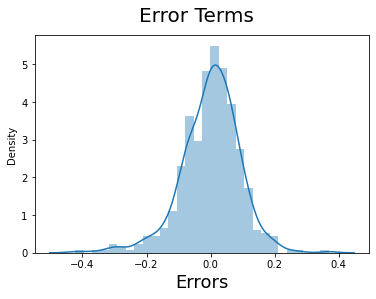

In [55]:
#Compute Residuals/error terms and Plot the histogram of the error terms
fig = plt.figure()
res = y_train-y_train_pred
sns.distplot(res)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                        # X-label

#### We can conclude the assumption of linear regression that the error terms are normally distributed on train data

#### 2. Plot of Temp vs rental count to confirm the linear relation assumption of linear regression

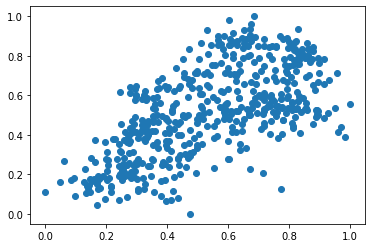

<Figure size 1440x1080 with 0 Axes>

In [71]:
plt.scatter(X_train_rfe.temp,y_train)
plt.figure(figsize = (20, 15))
plt.show()

#### we can see the linear relationship between temp and rental count variables

#### 3. Validate the homoscedasticity

Text(0, 0.5, 'Residuals')

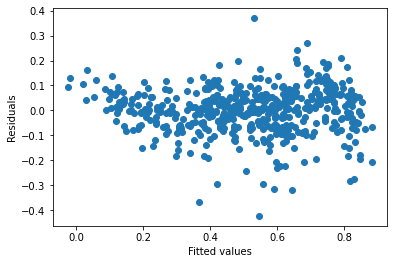

In [73]:
plt.scatter(y_train_pred, (y_train-y_train_pred))
plt.xlabel("Fitted values")
plt.ylabel("Residuals")

#### We can see that most of the residuals are near to 0, hence homoscedastic

### Predictions and Evaluation on the test dataset

In [60]:
num_vars = ["temp","humidity","windspeed","rental_count"]
scaler = MinMaxScaler()
bikes_df_test[num_vars] = scaler.fit_transform(bikes_df_test[num_vars])

In [61]:
bikes_df_test.head()

,year,holiday,workingday,temp,humidity,windspeed,rental_count,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Mon,Sat,Sun,Thur,Tue,Wed,Light_Rain,Mist_and_Cloudy,spring,summer,winter
184,0,1,0,0.837241,0.534223,0.149393,0.704300,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
535,1,0,1,0.911423,0.470417,0.231142,0.725421,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
299,0,0,0,0.496221,0.777843,0.443398,0.278853,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1
221,0,0,1,0.890387,0.236659,0.449707,0.545512,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
152,0,0,0,0.821739,0.070765,0.682387,0.569148,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [62]:
bikes_df_test[num_vars].describe()

,temp,humidity,windspeed,rental_count
count,219.000000,219.000000,219.000000,219.000000
mean,0.546312,0.508750,0.418870,0.516216
std,0.249189,0.201253,0.188111,0.238702
min,0.000000,0.000000,0.000000,0.000000
25%,0.328479,0.358469,0.283817,0.359882
50%,0.546045,0.494200,0.402533,0.520241
75%,0.759735,0.651165,0.524362,0.682487
max,1.000000,1.000000,1.000000,1.000000


In [63]:
# Splitting into X and y test data
y_test = bikes_df_test.pop("rental_count")
X_test = bikes_df_test

In [64]:
# retain the columns from RFE
retain = list(X_train_rfe.columns[1:])
retain

['year',
 'holiday',
 'temp',
 'windspeed',
 'Jul',
 'Sep',
 'Light_Rain',
 'Mist_and_Cloudy',
 'spring',
 'winter']

In [65]:
X_test_rfe = X_test[retain]
X_test_rfe.head()

,year,holiday,temp,windspeed,Jul,Sep,Light_Rain,Mist_and_Cloudy,spring,winter
184,0,1,0.837241,0.149393,1,0,0,1,0,0
535,1,0,0.911423,0.231142,0,0,0,0,0,0
299,0,0,0.496221,0.443398,0,0,0,1,0,1
221,0,0,0.890387,0.449707,0,0,0,0,0,0
152,0,0,0.821739,0.682387,0,0,0,0,0,0


In [66]:
# Adding a constant
X_test_rfe = sm.add_constant(X_test_rfe)

In [67]:
#Predict the values of the target variable
y_pred = lm_model.predict(X_test_rfe)

In [68]:
#Calculate the r2 value
r2_score(y_test,y_pred)

0.7953777856921883

### Residual Analysis on Test dataset

Text(0.5, 0, 'Errors')

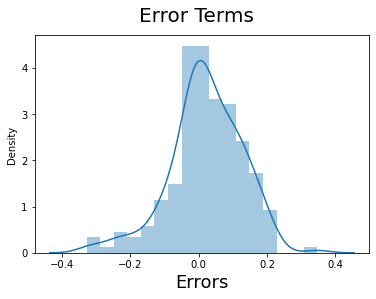

In [69]:
#Compute Residuals/error terms and Plot the histogram of the error terms
fig = plt.figure()
res = y_test-y_pred
sns.distplot(res)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                        # X-label

#### We can conclude the assumption of linear regression that the error terms are normally distributed on test data

### Model Evaluation
####  Graph for actual versus predicted values.

Text(0, 0.5, 'y_pred')

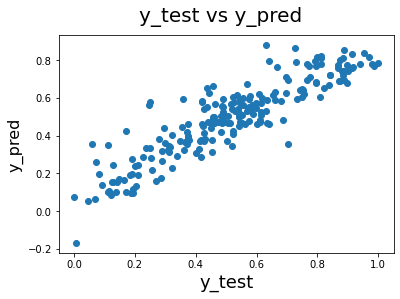

In [70]:
# Plotting y_test and y_pred to understand the spread
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)  

We can see that the equation of our best fitted line is:

$ Rental Count = 0.2341 \times  year - 0.0986  \times  holiday + 0.4515 \times temp -0.1398 \times windspeed -0.0727 \times jul + 0.0577 \times sep - 0.2864 \times Light Rain - 0.0811 \times Misty And Cloudy - 0.1108 \times spring + 0.0473 \times winter $

### Insights :

- The above is the equation of the best fitted line which indicates that when 1 unit of temperature increases the bike rental count will increase by 0.4515 and decrease by 0.0986 by increasing one unit of holiday
- The final value of r2 is 0.833 or 83.3% which tells that 83.3% of the variance in rental_count(Traget variable) is due to these predictor variables on Train data and on Test data it is 79.53%
- The final value of adj(r2) is 0.830 or 83% which tells the goodness of fit.

### Suggestions :

- We can suggest that bike company to strategise their sales during cloudy weather conditions as the bike rentals are low during that period
- The bike rentals are low from Nov to apr so we ask them to give some special discounts during this period.
- Also we can try to reduce the man power and sales during holidays as we can see that people are not renting much during holidays and we can increase during weekdays